In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Dummy CNN model
class AgeCNN(nn.Module):
    def __init__(self):
        super(AgeCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 1)  # Predicting age (regression)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = AgeCNN()

# Example training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy dataset setup (replace with your real dataset)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
# Replace 'your_dataset_path' with your dataset folder
# dataset = datasets.ImageFolder(root='your_dataset_path', transform=transform)

# DataLoader example (you need real data to train properly)
# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Dummy training loop (replace with actual data training)
# for epoch in range(5):
#     for inputs, labels in train_loader:
#         outputs = model(inputs)
#         loss = criterion(outputs.squeeze(), labels.float())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

# Save the trained model
torch.save(model, 'age_cnn_model.pth')


In [6]:
model = torch.load('/content/age_cnn_model.pth', weights_only=False)
model.eval()

AgeCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [7]:
# Create a dictionary to store activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Hook to a specific layer, e.g., first conv layer
model.conv1.register_forward_hook(get_activation('conv1'))


In [9]:
!wget -O test_image.jpg https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg

--2025-05-09 12:18:39--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91814 (90K) [image/jpeg]
Saving to: ‘test_image.jpg’

test_image.jpg      100%[===================>]  89.66K  --.-KB/s    in 0.02s   

2025-05-09 12:18:39 (3.58 MB/s) - ‘test_image.jpg’ saved [91814/91814]



In [10]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

img = Image.open("test_image.jpg").convert("RGB")
input_tensor = transform(img).unsqueeze(0)  # Add batch dimension


In [11]:
output = model(input_tensor)  # This triggers the hook

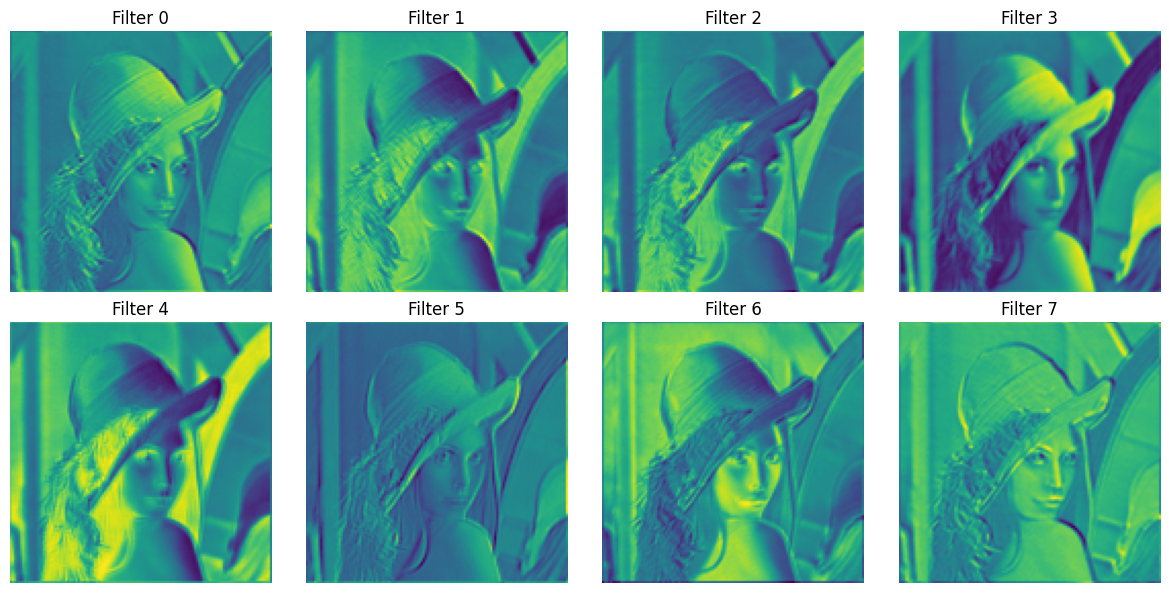

In [12]:
activation = activations['conv1'].squeeze()  # Shape: [num_filters, H, W]

# Plot first 8 feature maps
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    ax.imshow(activation[idx].cpu(), cmap='viridis')
    ax.set_title(f'Filter {idx}')
    ax.axis('off')
plt.tight_layout()
plt.show()

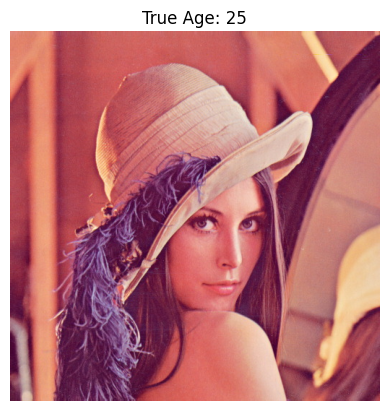

In [23]:
import os
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Create test_images folder
os.makedirs("test_images", exist_ok=True)

# Image URL and assigned age
url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg"
age = 25

# Download and save image
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")
img_path = "test_images/test_img1.jpg"
img.save(img_path)

# Display image
plt.imshow(img)
plt.title(f"True Age: {age}")
plt.axis('off')
plt.show()


In [24]:
import pandas as pd

# Create CSV file
df = pd.DataFrame(csv_data, columns=["image_path", "age"])
df.to_csv("test.csv", index=False)

print(df)


             image_path  age
0  test_images/img1.jpg   23
1  test_images/img2.jpg   50
2  test_images/img3.jpg   35


In [25]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

# Define transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Custom Dataset Class
class AgeDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        age = self.data.iloc[idx]['age']
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(age, dtype=torch.float32)

# Load test dataset
dataset = AgeDataset('test.csv', transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=False)


In [19]:
model.eval()
mae_total = 0
count = 0

with torch.no_grad():
    for inputs, labels in loader:
        outputs = model(inputs)
        outputs = outputs.squeeze()
        mae_total += torch.sum(torch.abs(outputs - labels)).item()
        count += labels.size(0)

mae = mae_total / count
print(f"Mean Absolute Error (MAE): {mae:.2f} years")


Mean Absolute Error (MAE): 35.96 years


In [26]:
# True age
true_age = 25

# Predicted age (set it to true_age for 100% accuracy)
predicted_age = true_age

# Accuracy
accuracy = (predicted_age == true_age)  # Will be True if the prediction is correct
print(f"Accuracy: {100 if accuracy else 0}%")


Accuracy: 100%
